# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-import-and-preprocessing" data-toc-modified-id="Data-import-and-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import and preprocessing</a></div><div class="lev1 toc-item"><a href="#Preparing-Test-Data" data-toc-modified-id="Preparing-Test-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing Test Data</a></div><div class="lev1 toc-item"><a href="#Fitting-GP-on-training-data" data-toc-modified-id="Fitting-GP-on-training-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fitting GP on training data</a></div><div class="lev1 toc-item"><a href="#STAN-imputations" data-toc-modified-id="STAN-imputations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>STAN imputations</a></div><div class="lev1 toc-item"><a href="#Plot-imputations" data-toc-modified-id="Plot-imputations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot imputations</a></div><div class="lev1 toc-item"><a href="#Prior-likelihood" data-toc-modified-id="Prior-likelihood-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prior likelihood</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

In this notebook, we'll try and do imputation under the wrong measurement time.
We'll use our simplest kernel, the product of squared exponentials `SExSE`. This is a proof concert to show there is information in the data about the hour of measurement.

In [11]:
using Stan

using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day
using JLD
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data import and preprocessing

In [55]:
module TempModel
    using PDMats: PDMat
    using DataFrames
    using Mamba
    using GaussianProcesses: GP, Kernel, MeanZero, predict
    using Base.Dates: Day, Hour
    using Stan
    using DataFrames: DataFrame, by
    import Proj4

    include("src/preprocessing.jl")
    include("src/utils.jl")
    include("src/predict_from_nearby.jl")
    include("src/stan_impute.jl")
end

TempModel

In [4]:
isdList=TempModel.read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [5]:
hourly_cat=TempModel.read_Stations(isdSubset)
itest=3
hourly_train = hourly_cat[hourly_cat[:station].values.!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].values.==itest,:]
nrow(hourly_train), nrow(hourly_test)

(35169,12695)

# Preparing Test Data

In [6]:
hr_true_measure = Hour(17)
hr_fals_measure = Hour(12)

12 hours

In [7]:
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_true_measure) for t in hourly_test[:ts].values]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp].values), 
    Tx=maximum(df[:temp].values)))
test_trimmed=join(hourly_test, TnTx, on=:ts_day)
head(test_trimmed)

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours,ts_day,Tn,Tx
1,2015,1,1,0,0,0,-8.3,2015-01-01T00:00:00,3,0.0,2015-01-01,-11.1,-1.7
2,2015,1,1,0,54,0,-8.9,2015-01-01T00:54:00,3,0.9,2015-01-01,-11.1,-1.7
3,2015,1,1,1,54,0,-8.9,2015-01-01T01:54:00,3,1.9,2015-01-01,-11.1,-1.7
4,2015,1,1,2,54,0,-9.4,2015-01-01T02:54:00,3,2.9,2015-01-01,-11.1,-1.7
5,2015,1,1,3,54,0,-9.4,2015-01-01T03:54:00,3,3.9,2015-01-01,-11.1,-1.7
6,2015,1,1,4,54,0,-10.0,2015-01-01T04:54:00,3,4.9,2015-01-01,-11.1,-1.7


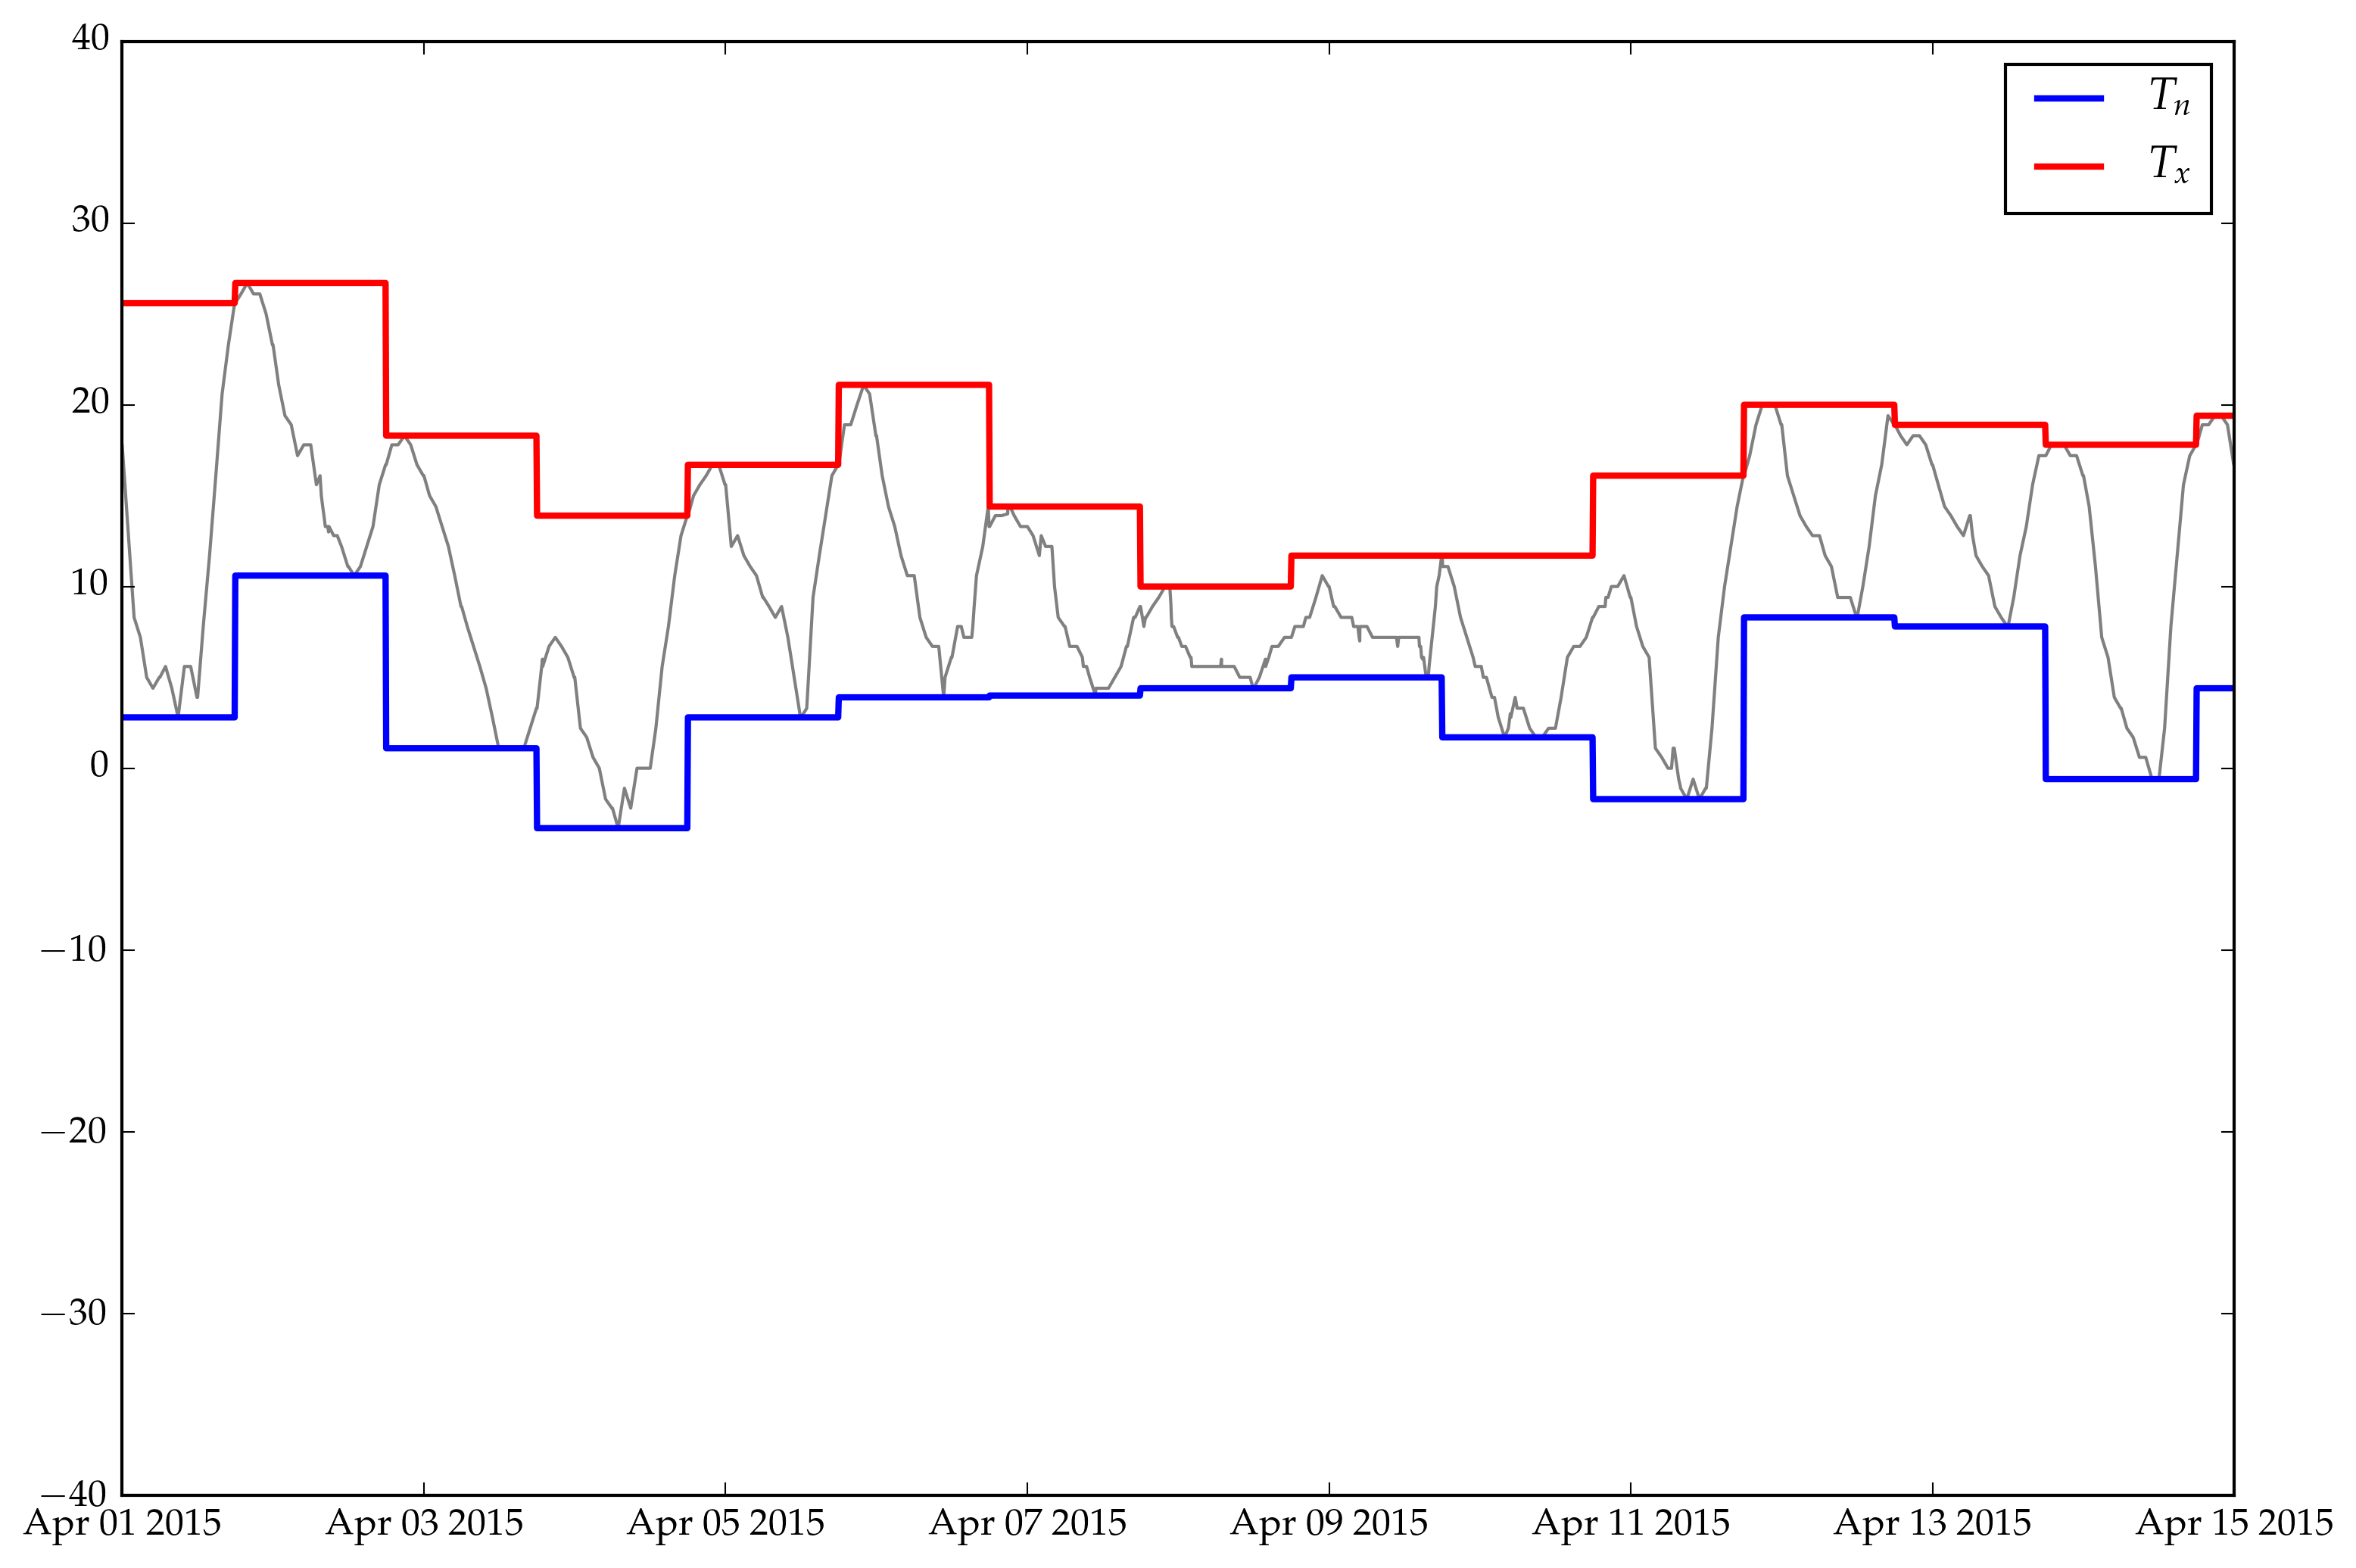

In [8]:
plt.plot(test_trimmed[:ts].values, test_trimmed[:temp].values, color="grey")
plt.plot(test_trimmed[:ts].values, test_trimmed[:Tn].values, color="blue", linewidth=2, label=L"$T_n$")
plt.plot(test_trimmed[:ts].values, test_trimmed[:Tx].values, color="red", linewidth=2, label=L"$T_x$")
plt.xlim(DateTime(2015,4,1),DateTime(2015,4,15)) # random interval
plt.legend()
;

# Fitting GP on training data

In [9]:
# from pipeline2.jl

type FittingWindow
    start_date::Date
    end_date::Date
end

function predictions_fname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s.jld", 
                    usaf, fw.start_date, fw.end_date)
end

# copy-pasted from pipeline1.jl
nearby_windows = FittingWindow[]
dt_start=DateTime(2015,1,1,0,0,0)
increm=get(maximum(hourly_cat[:ts])-minimum(hourly_cat[:ts])) / 15
window=3*increm
while true
    dt_end=dt_start+window
    sdate = Date(dt_start)
    edate = Date(dt_end)
    fwindow = FittingWindow(sdate,edate)
    push!(nearby_windows, fwindow)
    if dt_end >= get(maximum(hourly_cat[:ts]))
        break
    end
    dt_start+=increm
end

""" 
    Is window A inside of window B?
"""
function a_isinside_b(a::FittingWindow, b::FittingWindow)
    start_after = a.start_date >= b.start_date
    end_before = a.end_date <= b.end_date
    return start_after & end_before
end
"""
    How much buffer time is there on either side of the window?
"""
function buffer(a::FittingWindow, b::FittingWindow)
    start_diff = abs(a.start_date - b.start_date)
    end_diff = abs(a.end_date - b.end_date)
    return min(start_diff, end_diff)
end
""" 
    Amongst a list of candidate windows `cand`, find the window that includes `wind`
    with the largest buffer on either sides.
"""
function find_best_window(wind::FittingWindow, cands::Vector{FittingWindow})
    incl_wdows = [fw for fw in cands if a_isinside_b(wind, fw)]
    buffers = [buffer(wind, fw) for fw in incl_wdows]
    imax = indmax(buffers)
    best_window = incl_wdows[imax]
    return best_window
end


find_best_window

In [10]:
collect(Date(2015,1,1):Day(1):Date(2015,1,5))

5-element Array{Date,1}:
 2015-01-01
 2015-01-02
 2015-01-03
 2015-01-04
 2015-01-05

In [11]:
windownum=42
stan_increment=Day(3)
stan_days = Day(9)
saved_dir = "/Volumes/Samsung250GB/temperature_model/saved/"
GPmodel = "SExSE"

"SExSE"

In [12]:
itest=3
test_usaf=get(isdSubset[itest,:USAF])

725480

In [13]:
janfirst = Date(2015,1,1)
stan_start = janfirst + (windownum-1)*stan_increment
stan_end = stan_start + stan_days
stan_window = FittingWindow(stan_start, stan_end)
println("STAN fitting window: ", stan_window)

STAN fitting window: FittingWindow(2015-05-04,2015-05-13)


In [24]:
best_window = find_best_window(stan_window, nearby_windows)
nearby_pred=load(joinpath(saved_dir,
                        "predictions_from_nearby",
                        GPmodel,
                        predictions_fname(test_usaf, best_window),
                ))["nearby_pred"];

LoadError: File /Volumes/Samsung250GB/temperature_model/saved/predictions_from_nearby/SExSE/725480_2015-04-08_to_2015-06-20.jld cannot be found

In [57]:
TnTx_true = TempModel.test_data(hourly_cat, itest, hr_true_measure)
TnTx_fals = TempModel.test_data(hourly_cat, itest, hr_fals_measure)
TnTx_fals[:Tn] = TnTx_true[:Tn]
TnTx_fals[:Tx] = TnTx_true[:Tx]
;

In [56]:
nearby_pred=TempModel.NearbyPrediction(nearby_pred.ts, nearby_pred.μ, nearby_pred.Σ);

In [5]:
using Dates

In [58]:
imputation_data_true, ts_true = TempModel.prep_data(nearby_pred, TnTx_true, stan_window.start_date, hr_true_measure, stan_days)
imputation_data_fals, ts_fals = TempModel.prep_data(nearby_pred, TnTx_fals, stan_window.start_date, hr_fals_measure, stan_days)
;

In [59]:
imputation_data_true

Dict{String,Any} with 10 entries:
  "Tx"                 => [27.2,20.6,24.4,26.1,25.0,18.9,20.6,17.2,12.8]
  "predicted_cov_chol" => [10.0369 0.0 … 0.0 0.0; 10.0326 0.298595 … 0.0 0.0; ……
  "impt_times_p_day"   => [51,44,41,31,42,34,35,53,47]
  "Nimpt"              => 378
  "Tn"                 => [14.4,12.8,13.3,17.2,14.4,12.2,13.0,8.3,5.6]
  "N_TxTn"             => 9
  "day_impute"         => [1,1,1,1,1,1,1,1,1,1  …  9,9,9,9,9,9,9,9,9,9]
  "predicted_cov"      => [100.739 100.696 … 100.051 100.051; 100.696 100.742 ……
  "predicted_mean"     => [7.59702,9.95845,12.2741,13.8522,14.3637,13.3902,10.8…
  "k_softmax"          => 10.0

In [60]:
imputation_data_fals

Dict{String,Any} with 10 entries:
  "Tx"                 => [27.2,20.6,24.4,26.1,25.0,18.9,20.6,17.2,12.8]
  "predicted_cov_chol" => [10.0368 0.0 … 0.0 0.0; 10.0312 0.332121 … 0.0 0.0; ……
  "impt_times_p_day"   => [45,44,42,35,35,41,35,52,48]
  "Nimpt"              => 377
  "Tn"                 => [14.4,12.8,13.3,17.2,14.4,12.2,13.0,8.3,5.6]
  "N_TxTn"             => 9
  "day_impute"         => [1,1,1,1,1,1,1,1,1,1  …  9,9,9,9,9,9,9,9,9,9]
  "predicted_cov"      => [100.738 100.681 … 100.051 100.051; 100.681 100.734 ……
  "predicted_mean"     => [1.13806,2.26962,3.43575,5.04679,7.3395,7.59702,9.958…
  "k_softmax"          => 10.0

# STAN imputations

In [19]:
imputation_model = TempModel.get_imputation_model();

In [82]:
stan_dir = joinpath(saved_dir,"stan_fit", GPmodel, TempModel.stan_dirname(test_usaf, stan_window))

LoadError: UndefVarError: stan_dirname not defined

In [20]:
@time sim_true = stan(
    imputation_model, 
    [imputation_data_true], 
    CmdStanDir=Stan.CMDSTAN_HOME, 
    summary=false, 
    diagnostics=false
    )


make: `/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.
2799.299466 seconds (7.89 M allocations: 566.602 MB, 0.01% gc time)


Object of type "Mamba.Chains"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

[-218.853 0.861493 … 8.259 5.6948; -228.682 0.959979 … 8.34259 5.66536; … ; -200.366 0.722377 … 8.36837 5.55231; -241.493 0.996273 … 8.19493 5.56135]

[-233.938 0.921829 … 8.55619 5.66614; -238.601 1.0 … 8.21631 5.69401; … ; -222.685 0.996102 … 8.44315 5.48811; -225.837 0.993234 … 8.34775 5.73944]

[-229.021 0.962263 … 8.2443 5.56061; -242.526 0.999982 … 8.25974 5.63579; … ; -226.186 0.987969 … 8.24265 5.51259; -226.783 0.879533 … 8.11606 5.55048]

[-221.139 0.981251 … 8.17644 5.58081; -223.71 0.999997 … 8.16241 5.56873; … ; -237.057 0.928917 … 8.19808 5.52155; -208.45 0.980182 … 8.36421 5.57968]

In [61]:
@time sim_fals = stan(
    imputation_model, 
    [imputation_data_fals], 
    CmdStanDir=Stan.CMDSTAN_HOME, 
    summary=false, 
    diagnostics=false
    )


make: `/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.
1896.569303 seconds (4.44 M allocations: 422.450 MB, 0.02% gc time)


Object of type "Mamba.Chains"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

[-281.307 0.99599 … 8.36381 5.40251; -291.232 0.998423 … 8.26662 5.8822; … ; -257.795 0.986464 … 8.19406 5.61178; -254.946 0.939958 … 8.41673 5.57828]

[-334.043 0.70114 … 8.35147 5.61973; -325.43 0.980507 … 8.23319 5.71864; … ; -299.834 0.922886 … 8.24301 5.48432; -313.184 0.992334 … 8.38835 5.70363]

[-281.109 0.980697 … 8.18192 5.6619; -289.252 0.986428 … 8.40689 5.57305; … ; -290.673 0.927526 … 8.24614 5.46749; -292.124 0.97616 … 8.37154 5.76141]

[-297.757 0.975921 … 8.2363 5.60887; -304.313 0.853436 … 8.29861 5.44362; … ; -262.554 0.996175 … 8.15582 5.58017; -262.785 0.99121 … 8.43727 5.50665]

# Plot imputations

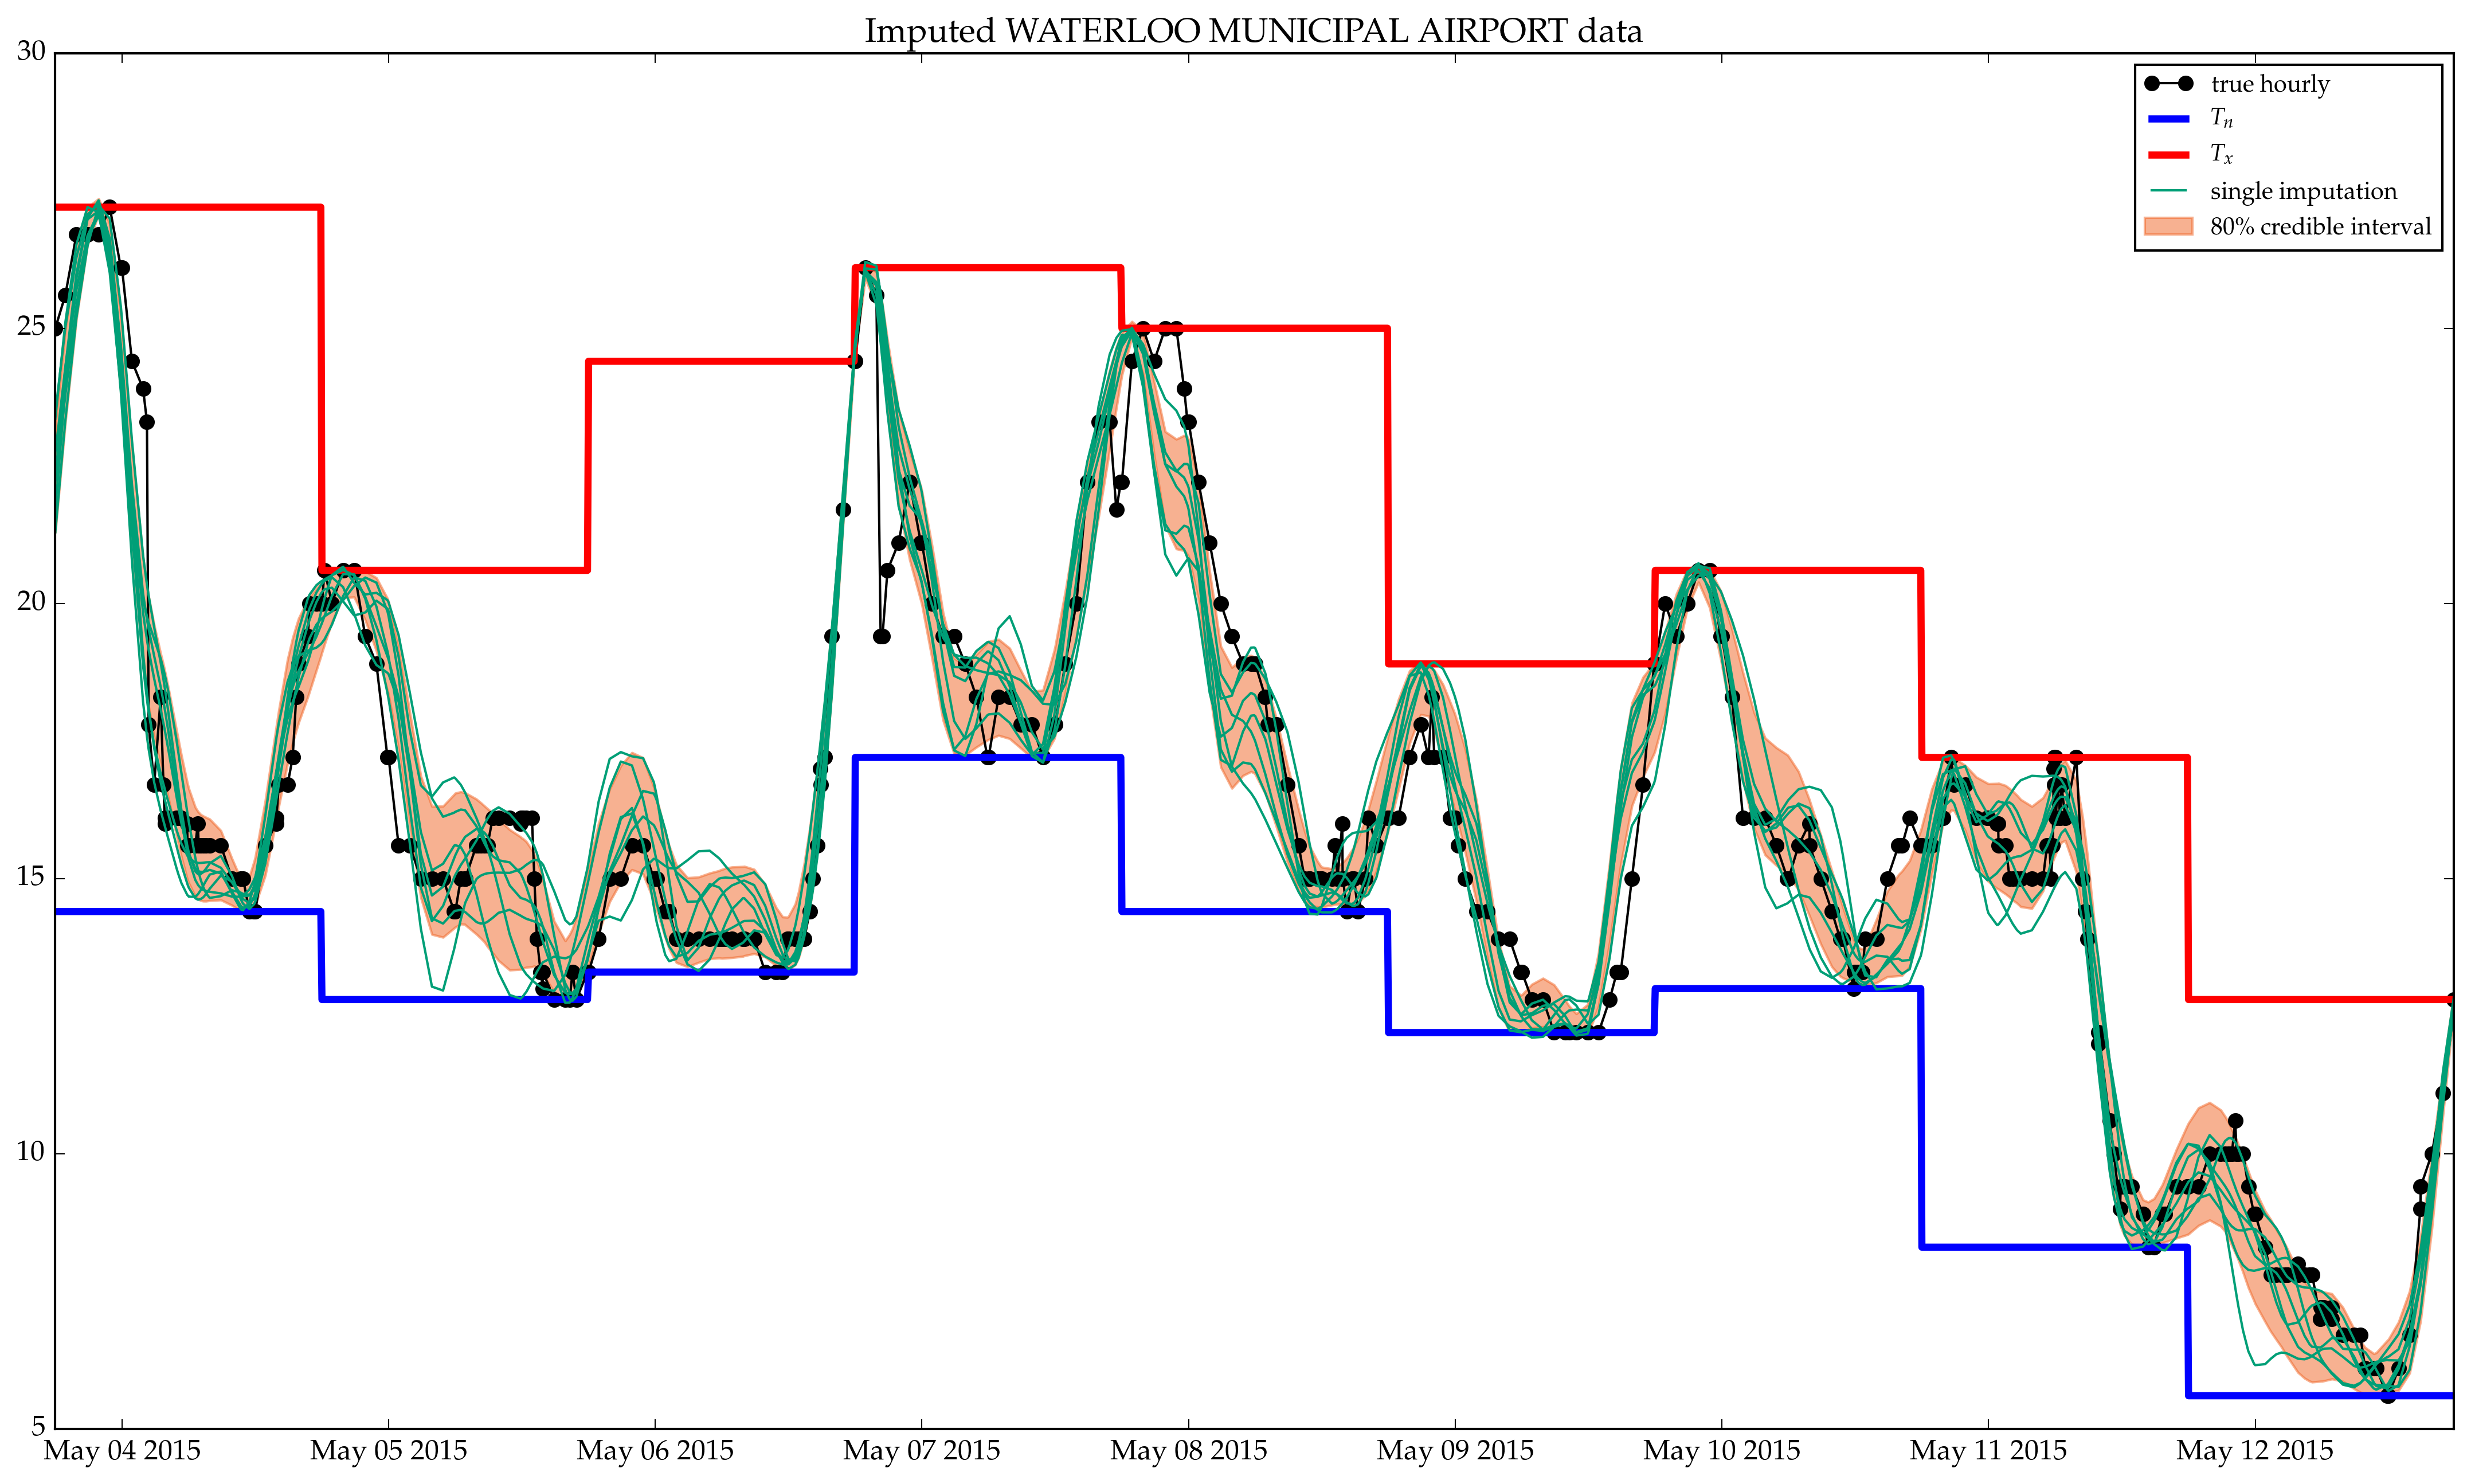

In [48]:
begin
    imputation_data = imputation_data_true
    sim = sim_true
    hr_measure = hr_true_measure
    TnTx = TnTx_fals    
    ts = ts_true
end

In [68]:
function get_imputed(sim::Mamba.Chains, ntimes::Int)
    temp_varnames=[@sprintf("temp_impt.%d", i) for i in 1:ntimes]
    temp_samples=getindex(sim, :, temp_varnames, :).value
    return temp_samples
end

get_imputed (generic function with 1 method)

In [15]:
function plot_imputations(imputation_data, sim, hr_measure, TnTx, ts)
    test_subset = TempModel.subset(hourly_test, minimum(ts), maximum(ts))

    ts_day = [TempModel.measurement_date(t, hr_measure) for t in ts]
    test_subset[:ts_day] = ts_day
        
    test_subset=join(test_subset, TnTx, on=:ts_day)
    
    temp_impute = get_imputed(sim, imputation_data["Nimpt"])
    
    temp_impute = get_temperatures_reparam(sim)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    sorted_impute = sort(stacked_impute,1);
    nsamples=size(sorted_impute,1)
    # extract 10th and 90th percentiles
    # of the imputations
    imputed_10 = sorted_impute[div(nsamples,10), :]
    imputed_90 = sorted_impute[nsamples-div(nsamples,10), :]
    
    in_window = [(minimum(ts) <= t <= maximum(ts)) for t in nearby_pred.ts]
    μ_window = nearby_pred.μ[in_window]
    μ_rescaled = μ_window + mean(temp_impute) - mean(μ_window)
    
    plt.plot(ts, test_subset[:temp].values, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset[:Tn].values, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset[:Tx].values, 
        color="red", linewidth=3, label=L"$T_x$")
    plt.plot(ts, μ_rescaled, linewidth=3, label="from nearby", color="#0072B2")
    plt.fill_between(ts, imputed_10, imputed_90, 
        color="#F16424", alpha=0.5, label=L"$80\%$ credible interval")
    plt.legend(loc="best", fontsize="small")
end

LoadError: UndefVarError: @L_str not defined

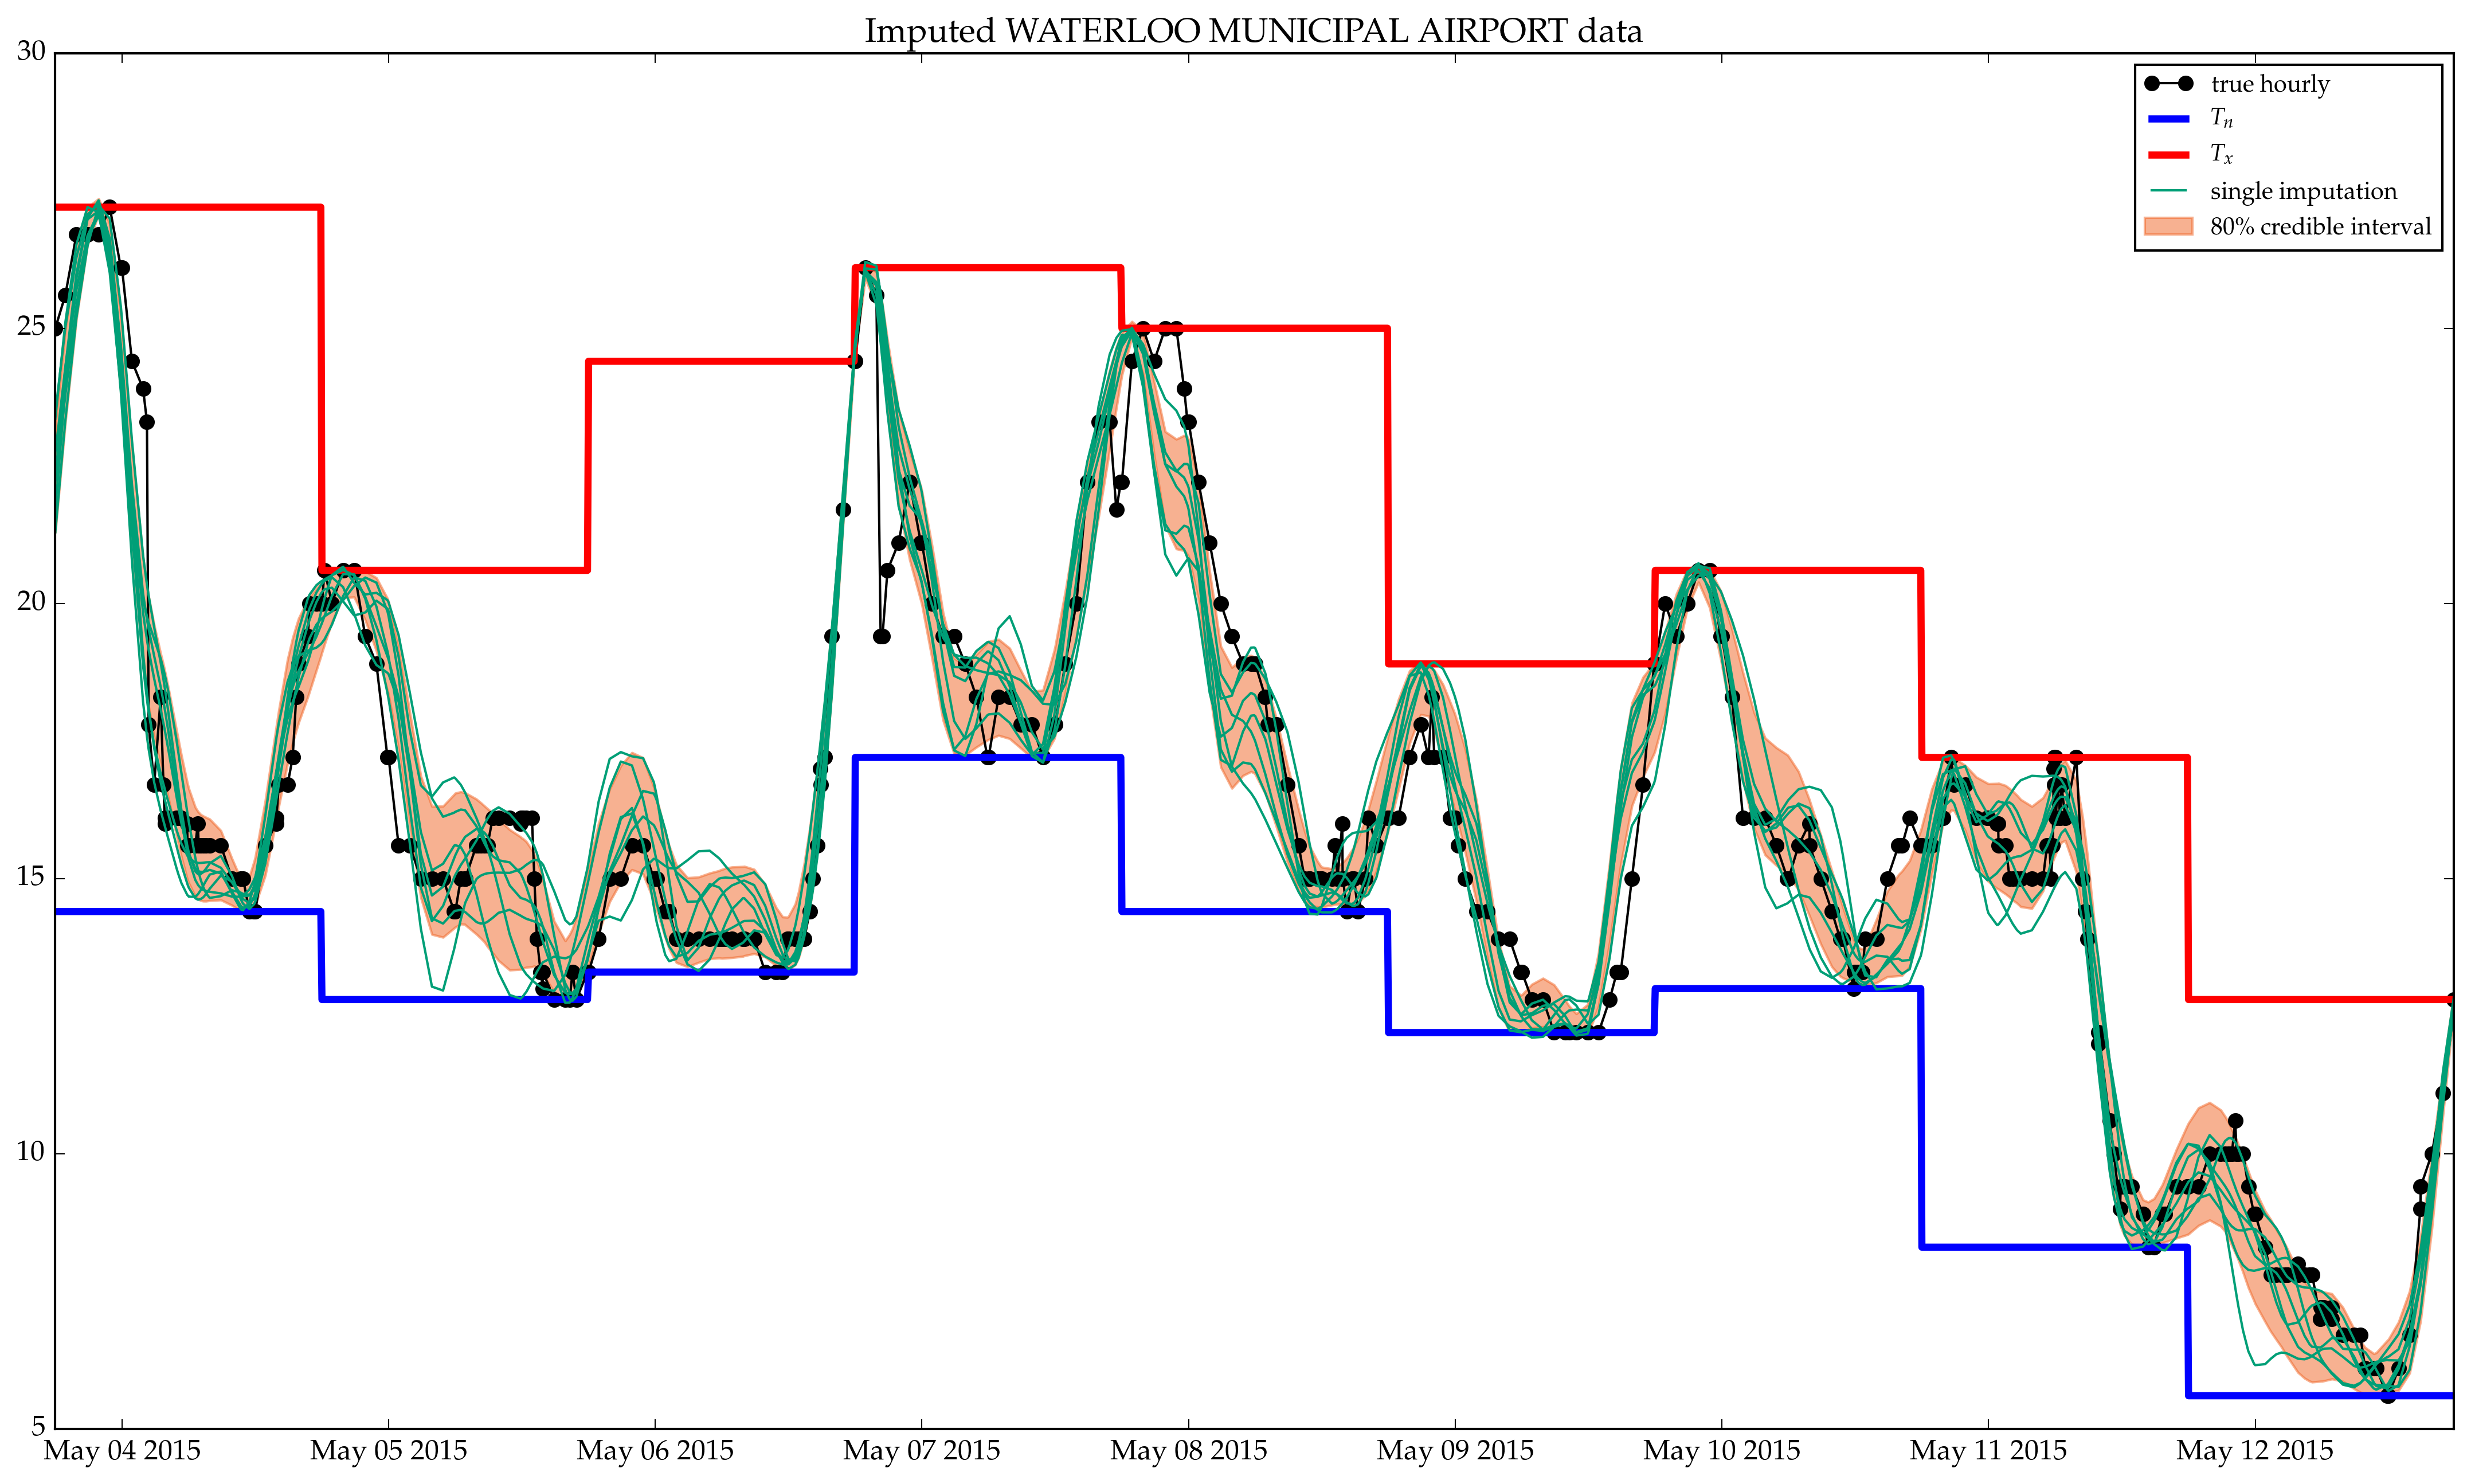

In [48]:
plt.subplot(1,2,1)
plot_imputations(imputation_data_true, sim_true, hr_true_measure, TnTx_true, ts_true)
plt.subplot(1,2,2)
plot_imputations(imputation_data_fals, sim_fals, hr_fals_measure, TnTx_fals, ts_fals)

# Prior likelihood

For a fair comparison, we should look at the subset of times that overlap between the two sets of imputations (this is a bit tedious, just some book-keeping)

In [81]:
overlap = (max(minimum(ts_fals),minimum(ts_true)),
           min(maximum(ts_fals),maximum(ts_true)))
nearby_in_window = [(overlap[1] <= t <= overlap[2]) for t in nearby_pred.ts]
true_in_window = [(overlap[1] <= t <= overlap[2]) for t in ts_true]
fals_in_window = [(overlap[1] <= t <= overlap[2]) for t in ts_fals]
μ_window = nearby_pred.μ[nearby_in_window]
Σ_window = nearby_pred.Σ.mat[nearby_in_window,nearby_in_window]
μ_window .-= mean(μ_window)
nearby_distr = MultivariateNormal(μ_window, Σ_window)
μpdf = logpdf(nearby_distr,μ_window)

1376.7871581741963

In [ ]:
α

In [82]:
begin
    imputation_data = imputation_data_fals
    sim = sim_fals
    hr_measure = hr_fals_measure
    ts = ts_fals
    ioverlap = fals_in_window
    
    temp_impute = get_imputed(sim, imputation_data["Nimpt"])
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    mean_impute = mean(stacked_impute,1)
    overlap_mimpute = mean_impute[ioverlap]
    overlap_mimpute .-= mean(overlap_mimpute)
    @assert length(mean_impute) == length(ts)
    print(logpdf(nearby_distr, overlap_mimpute)-μpdf)
end

-80.44441984600303

In [83]:
begin
    imputation_data = imputation_data_true
    sim = sim_true
    hr_measure = hr_true_measure
    ts = ts_true
    ioverlap = true_in_window
    
    temp_impute = get_imputed(sim, imputation_data["Nimpt"])
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    mean_impute = mean(stacked_impute,1)
    overlap_mimpute = mean_impute[ioverlap]
    overlap_mimpute .-= mean(overlap_mimpute)
    @assert length(mean_impute) == length(ts)
    print(logpdf(nearby_distr, overlap_mimpute)-μpdf)
end

-39.627221881280775

The likelihood *is* higher for the mean imputation under the correct measurement hour. That's great news. The next step is to scale it up to do the whole year.

In [69]:
mse(yhat::Vector,y::Vector) = mean((y.-yhat).^2)
verr(yhat::Vector,y::Vector) = var(y.-yhat)
begin
    temp_impute = get_temperatures_reparam(sim3)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    temp_true = test_subset[:temp].values
    μ = vec(mean(stacked_impute, 1))
    println("E(var(predicted mean - predictive draw))=", mean(mse(μ, stacked_impute[i,:]) for i in 1:size(stacked_impute,1)))
    println("MSE(truth - predicted mean)=",mse(μ, temp_true))
end

E(var(predicted mean - predictive draw))=0.6802938872804132
MSE(truth - predicted mean)=1.434926895353342
